<a href="https://colab.research.google.com/github/gerasimos-matidis/my_icdar/blob/main/net_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount google drive and move to the project's directory
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/MyDrive/my_icdar

In [ ]:
import os
import tensorflow as tf

from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

try:
    from patchify import (patchify, unpatchify)
except:
    % pip install patchify
    from patchify import (patchify, unpatchify)

In [ ]:
# Display a list with the available models and ask the user to choose which to use
models_path = 'models'
models_list = os.listdir(models_path)

# create a dictionary with numbers as keys and the model names as values
models2dict = dict([(str(a), b) for a, b in enumerate(models_list)])

print('List of Models', '--------------', sep='\n')
for item in models2dict.items():
    print(*item, sep=' --> ')

print('\nChoose a model from the list by typing the number of its key + Enter:')
model_name = models2dict[input()]
print(f'\n{model_name} was selected.')

In [ ]:
# Load the model
model = keras.models.load_model(os.path.join(models_path, model_name))

In [ ]:
# Display the model's architecture
print(model.summary())

In [ ]:
# Retrieve the input layer and extract the size of width of the images (which is equal to the height)
input_layer = model.get_layer(index=0)
input_size = input_layer.input_shape[0][1]

In [ ]:
# Load the input and ground truth images 
x_initial_valid = plt.imread('validation/201-INPUT.jpg')
y_initial_valid = plt.imread('validation/201-OUTPUT-GT.png')

# Crop the images to remove the pixels that contain no information.
# Additionally, the width and height of the picture are managed to have a size of multiple integers of 512
x_initial_valid = x_initial_valid[500:6132, :8704]
y_initial_valid = y_initial_valid[500:6132, :8704]

In [ ]:
print(tf.shape(x_initial_valid))

In [ ]:
print(x_initial_valid.shape)

In [ ]:
# Create patches from the input and ground truth images
STEP = 256 # CAUTION!!!!! A lower value will cause a RAM overload
input_patches = np.squeeze(patchify(x_initial_valid, (input_size, input_size, 3), step=STEP))
ground_truth_patches = np.squeeze(patchify(y_initial_valid, (input_size, input_size), step=STEP))

# reshape the input_patches to the appropriate dimensions for the network, i.e. (patches_number, width, height, channels)
#reshaped_patches = np.reshape(input_patches, (-1, input_size, input_size, 3))

# reshape the ground truth patches to shape (patches_number, width, height)
#reshaped_ground_truth_patches = np.reshape(ground_truth_patches, (-1, input_size, input_size))

#del x_initial_valid, y_initial_valid

In [ ]:
input_patches.shape


In [ ]:
predictions = np.squeeze(model.predict(np.reshape(input_patches, (-1, input_size, input_size, 3))))
predictions = np.reshape(predictions, ground_truth_patches.shape)

In [ ]:
overlapped_images = 2 * input_size/STEP

assert overlapped_images == int(overlapped_images)
overlapped_images = int(overlapped_images)
assert overlapped_images == 4

In [ ]:
patches_num_v = predictions.shape[0]
patches_num_h = predictions.shape[1]
patch_aspect = int(input_size)
half_patch_aspect = int(patch_aspect/2)

augmented_predictions = np.empty(y_initial_valid.shape + (overlapped_images, ))
augmented_predictions[:] = np.NaN

for v in range(patches_num_v):
    for h in range(patches_num_h):

        v_zero = STEP * v
        start_v = v_zero
        middle_v = v_zero + half_patch_aspect
        end_v = v_zero + patch_aspect
        
        h_zero = STEP * h
        start_h = h_zero
        middle_h = h_zero + half_patch_aspect
        end_h = h_zero + patch_aspect
        
        if v == 0 and h == 0:
            augmented_predictions[0:patch_aspect, 0:patch_aspect, 0] = predictions[v][h]
        
        elif v == 0:
            augmented_predictions[start_v:end_v, start_h:middle_h, 1] = predictions[v][h][:, 0:half_patch_aspect]
            augmented_predictions[start_v:end_v, middle_h:end_h, 0] = predictions[v][h][:, half_patch_aspect:]

        elif h == 0:
            augmented_predictions[start_v:middle_v, start_h:middle_h, 1] = predictions[v][h][0:half_patch_aspect, 0:half_patch_aspect]
            augmented_predictions[start_v:middle_v, middle_h:end_h, 2] = predictions[v][h][0:half_patch_aspect, half_patch_aspect:]
            augmented_predictions[middle_v:end_v, start_h:end_h, 0] = predictions[v][h][half_patch_aspect:, :]

        else:
            augmented_predictions[start_v:middle_v, start_h:middle_h, 3] = predictions[v][h][0:half_patch_aspect, 0:half_patch_aspect]
            augmented_predictions[start_v:middle_v, middle_h:end_h, 2] = predictions[v][h][0:half_patch_aspect, half_patch_aspect:]
            augmented_predictions[middle_v:end_v, start_h:middle_h, 1] = predictions[v][h][half_patch_aspect:, 0:half_patch_aspect]
            augmented_predictions[middle_v:end_v, middle_h:end_h, 0] = predictions[v][h][half_patch_aspect:, half_patch_aspect:]
        

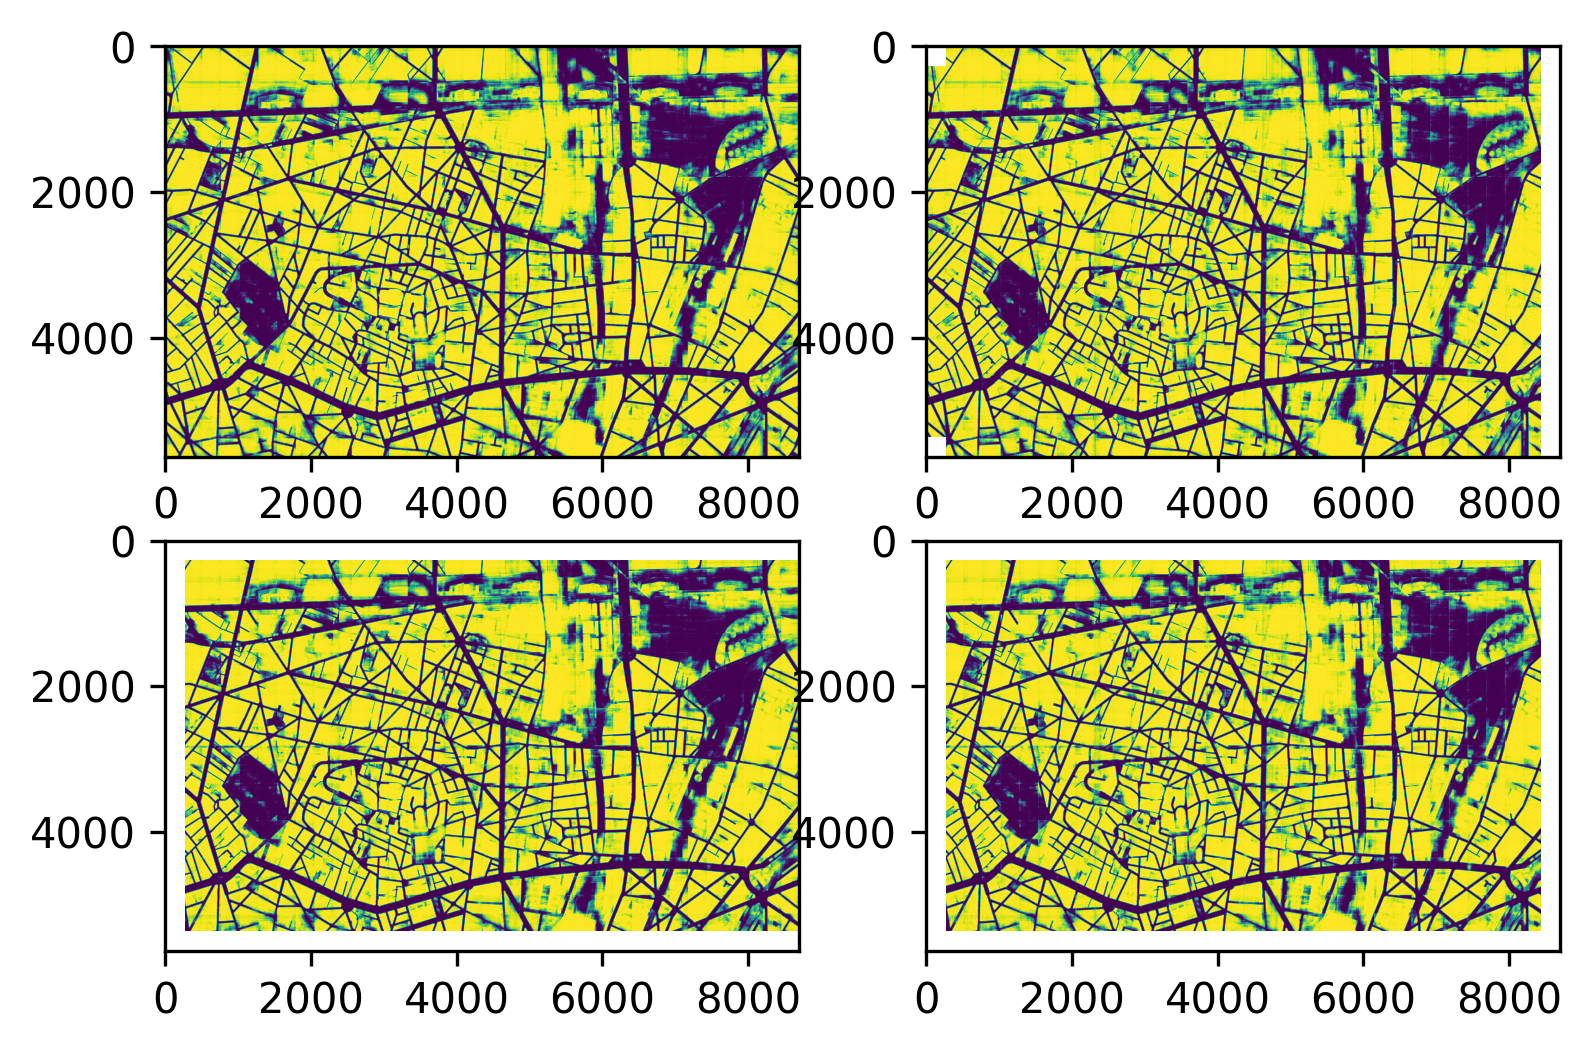

In [ ]:
fig, ax = plt.subplots(2, 2, dpi=300)

ax[0, 0].imshow(augmented_predictions[:, :, 0])
ax[0, 1].imshow(augmented_predictions[:, :, 1])
ax[1, 0].imshow(augmented_predictions[:, :, 2])
ax[1, 1].imshow(augmented_predictions[:, :, 3])
plt.show()

In [ ]:
new_pred = augmented_predictions[STEP:-STEP, STEP:-STEP]

pixelwise_std = np.std(new_pred, axis=2)


In [ ]:
np.savez_compressed('merged_predictions', data=new_pred)

In [ ]:
np.mean(pixelwise_std)

0.024076554233847646

In [ ]:
new_pred[100, 258]

array([0.99888235, 0.9802838 , 0.99887413, 0.98024863])

In [ ]:
import scipy.io

scipy.io.savemat('merged_predictions.mat', {'data': new_pred}, do_compression=True)

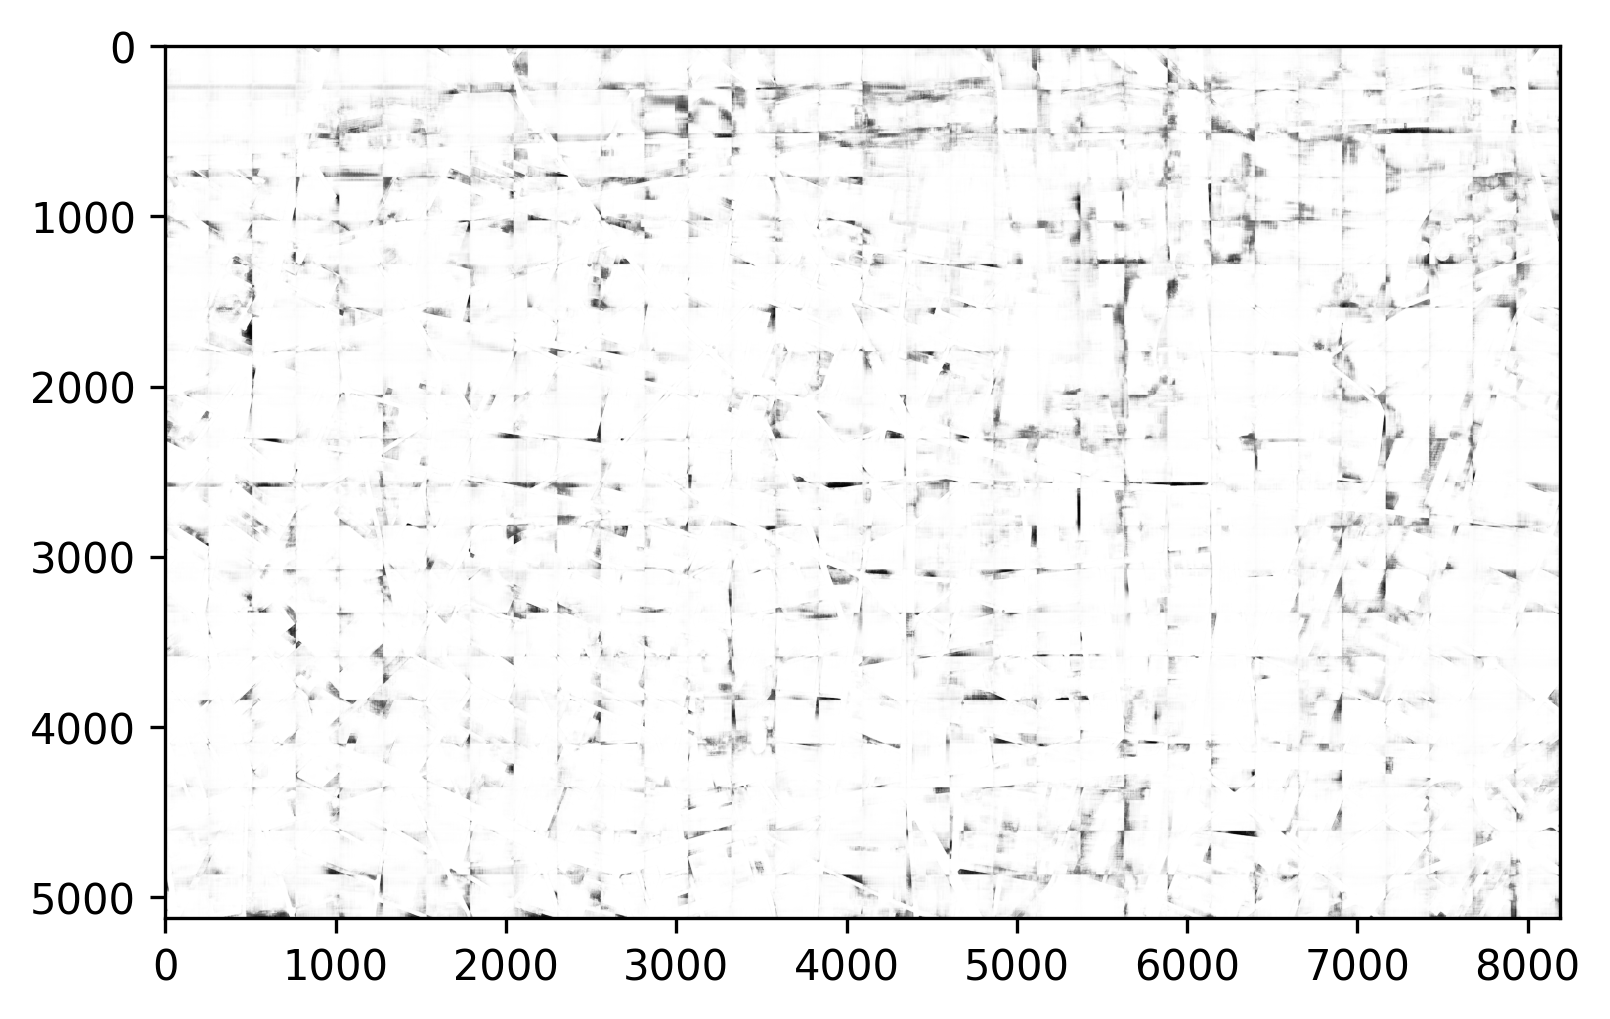

In [ ]:
plt.figure(dpi=300)
plt.imshow(1-pixelwise_std, cmap='Greys_r')
plt.show()

In [ ]:
#predictions = np.where(predictions>0.5, 1, 0)